# Preliminaries + Installs

These instructions are for Python 3.10
### Fix Pillow
* `cd /usr/lib/python3/dist-packages`
* `sudo rm -rf pillow-10.2.0.egg-info`
* `python3.10 -m pip install Pillow --user`
### Install Ollama
* `cd /tmp`
* `curl -fsSL https://ollama.com/install.sh | sh`
* Test, Optional (2GB download): `ollama run llama3.2`, Type `/bye` when done
### Install Langchain
* `python3.10 -m pip install langchain langchain_community langchain_chroma langchain_ollama llama-index-legacy langchain-unstructured --user`
* `python3.10 -m pip install pypdf "unstructured[pdf]" --user` , This needed to be separate for some reason.
### Install SQLite ( >= 3.35.0 required, This will install 3.46 )
* `sudo apt install libreadline-dev python3.10-dev`
* `wget https://sqlite.org/2024/sqlite-autoconf-3460100.tar.gz`
* `tar -xvf sqlite-autoconf-3460100.tar.gz && cd sqlite-autoconf-3460100`
* `./configure`
* `make`
* `sudo make install`
* `python3.10 -m pip uninstall pysqlite3`
* `python3.10 -m pip install pysqlite3-binary --user`

# Build/Expand Document Database + Embeddings

## State

In [1]:
from os import environ, path
import time, sys, json
now = time.time

from utils import RAG_State


environ["_RAG_STATE_PATH"] = "data/state.json"

RAGstate = RAG_State.load_state( environ["_RAG_STATE_PATH"] )

## Copy PDFs

In [2]:
import os
from os import path, makedirs
# from aa_scrape_PDF import copy_pdfs

environ["_RAG_PDF_SOURCE"] = "/media/james/FILEPILE/$_Robust_Planning/Literature/References/storage"
environ["_RAG_PDF_DESTIN"] = "data/input/pdf"
environ["_RAG_PDF_ERROR"]  = "data/input/BAD_PDF"
environ["_RAG_PAGE_DESTN"] = "data/input/pages"
environ["_RAG_VERBOSE"]    =    ""
environ["_RAG_DOC_ADD"]    =   "400" #"25" #"200"
environ["_RAG_DOC_LIMIT"]  = "20000"
environ["_RAG_DOC_DBASE"]  = "lit_pdf"
environ["_RAG_RUN_QUERY"]  = "True" #"" #"True"

if not path.exists( environ["_RAG_PDF_ERROR"] ):
    makedirs( environ["_RAG_PDF_ERROR"] )


## Determine if more docs will be loaded this session

In [3]:
%%capture
# Loading the vector store sometimes spews warnings

__import__('pysqlite3')
sys.modules['sqlite3'] = sys.modules.pop( 'pysqlite3' )
import chromadb
from langchain_chroma import Chroma


persistent_client = chromadb.PersistentClient();
collection        = persistent_client.get_or_create_collection( environ["_RAG_DOC_DBASE"] );

pdfs_drct   = environ["_RAG_PDF_DESTIN"]
eror_drct   = environ["_RAG_PDF_ERROR" ]
fNames      = [item for item in os.listdir( pdfs_drct ) if (str( item ).split('.')[-1].lower() == 'pdf')]

environ["_RAG_PDF_COUNT"   ] = str( len( fNames ) )
environ["_RAG_DOCDB_COUNT" ] = str( collection.count() )
environ["_RAG_DOCDB_REMAIN"] = str( min( int(environ["_RAG_DOC_LIMIT"])-len(RAGstate.docPaths), int(environ["_RAG_DOC_ADD"]) ) )


In [4]:
from utils import copy_pdfs

print( f"{environ['_RAG_PDF_COUNT' ]} input PDFs exist!" )
print( f"{environ['_RAG_DOCDB_COUNT' ]} vector records exist!" )
print( f"{environ['_RAG_DOCDB_REMAIN']} files will be copied!" )

copy_pdfs( environ["_RAG_PDF_SOURCE"], environ["_RAG_PDF_DESTIN"], 
           int(environ['_RAG_DOCDB_REMAIN']), verbose = environ["_RAG_VERBOSE"] )

10524 input PDFs exist!
231013 vector records exist!
400 files will be copied!
.........................................................................................................................................................................................................................


## Load PDFs by page chunks

### https://python.langchain.com/docs/how_to/document_loader_pdf/

* `python3.10 -m pip install pypdf langchain-unstructured "unstructured[pdf]" --user`
* `apt install tesseract-ocr`

In [5]:

def collect_unique_metadata_by_key( key ):
    """ Return a list of unqiue metadata values from the vector store by `key` """
    global collection
    unique = set()
    for result in collection.get()['metadatas']:
       if key in result:
           unique.add( result[key] )
    return list( unique )


def find_unread_PDFs_at_input():
    """ Return a list of PDF paths that do NOT have pages in the vector store """
    global RAGstate
    inputPDFs = collect_unique_metadata_by_key( 'source' )
    rtnPaths  = list()
    for pdf in inputPDFs:
        if pdf not in RAGstate['libDocs']:
            rtnPaths.append( pdf )
    return rtnPaths
            

In [6]:
import os, shutil
from collections import deque
from langchain_community.document_loaders import PyPDFLoader

pages = deque() # Fast append


# needToParse = find_unread_PDFs_at_input()
# fNames.extend( needToParse )

print( f"There are {len(fNames)} candidate files!" )

if len( fNames ) > 0:
    bgn    = now()
    lastLn = 0
    Nexist = 0
    
    for i, fNam in enumerate( fNames ):
        # file_path = str( path.join( pdfs_drct, fNam ) ) # fNam # str( path.join( pdfs_drct, fNam ) )
        file_path = fr"{path.join( pdfs_drct, fNam )}" # fNam # str( path.join( pdfs_drct, fNam ) )
        # file_path = file_path.replace( ' ', '\\ ' )
        # file_path = file_path.replace( ' ', '\\ ' )
        if file_path not in RAGstate.docPaths:
            try:
                loader    = PyPDFLoader( file_path )
                async for page in loader.alazy_load():
                    pages.append( page )
                print( f"{i+1}:{len(pages)-lastLn}:{len(pages)}", end = ', ', flush = True )
                lastLn = len(pages)
            except Exception as e:
                print( f"ERROR:{e}", end = ', ', flush = True )
                try:
                    # errr_path = str(path.join( eror_drct, fNam ))
                    errr_path = fr"{path.join( eror_drct, fNam )}"
                    # errr_path = errr_path.replace( ' ', '\\ ' )
                    shutil.move( file_path, errr_path )
                except Exception as e:
                    print( f"FAILED to move {file_path} --to-> {path.join( eror_drct, fNam )}" )
            except asyncio.CancelledError as e:
                print( f"Load operation cancelled by user" )
                raise e
        else:
            Nexist += 1
                    
    print()
    pages = list( pages )
    print( f"Read {len(pages)} pages in {(now()-bgn)/60.0:.2f} minutes! (Skipped {Nexist} existing PDFs.)" )

RAGstate.save_state( environ["_RAG_STATE_PATH"] )

There are 10524 candidate files!

Read 0 pages in 0.01 minutes! (Skipped 10524 existing PDFs.)


In [7]:
# print(f"{pages[0].metadata}\n")
# print(pages[0].page_content)

## Load the text embedding model

In [8]:
import sys, os, time
now = time.time

from utils import pull_ollama_model

from langchain_ollama import OllamaEmbeddings

pull_ollama_model( "all-minilm" )

local_embeddings = OllamaEmbeddings( model = "all-minilm" )

About to save 'all-minilm'.
This will spew a lot of text on the first run...


pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠦ pulling manifest 
pulling 797b70c4edf8... 100% ▕████████████████▏  45 MB                         
pulling c71d239df917... 100% ▕████████████████▏  11 KB                         
pulling 85011998c600... 100% ▕████████████████▏   16 B                         
pulling 548455b72658... 100% ▕████████████████▏  407 B                         
verifying sha256 digest 
writing manifest 
success 


## Populate document vector database (of pages)

In [9]:
import base64
import io

import fitz, pymupdf
from PIL import Image


def pdf_page_to_base64( pdf_path: str, page_number: int ):
    zoom_x       = 1.5  # horizontal zoom
    zoom_y       = 1.5  # vertical zoom
    mat          = pymupdf.Matrix( zoom_x, zoom_y )
    pdf_document = fitz.open( pdf_path )
    page         = pdf_document.load_page(page_number - 1)  # input is one-indexed
    pix          = page.get_pixmap( matrix = mat )
    img          = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
    buffer       = io.BytesIO()
    
    img.save( buffer, format="PNG" )

    return base64.b64encode( buffer.getvalue() ).decode("utf-8")

In [10]:
import pickle

from utils import gen_ID

if not path.exists( environ["_RAG_PAGE_DESTN"] ):
    makedirs( environ["_RAG_PAGE_DESTN"] )


def get_page_meta_key( source, page ):
    """ Generate a (probably not) unique page key with useful data that can also be used for sorting """
    return str( source ).split('/')[-1].replace(' ','') + '_' + str( page )


if int(environ["_RAG_DOCDB_REMAIN"]) > 0:
    bgn = now()
    docIDs  = [str( gen_ID() ) for _ in range( len(pages) )]
    dcmnts  = [str( pg.page_content ) for pg in pages]
    metaDt  = deque() # Fast append
    d       = 50
    readSet = set([])

    for i, pg in enumerate( pages ):

        id_i  = docIDs[i]
        
        # Save Text Metadata #
        mDct = pg.metadata
        mDct['metakey'] = get_page_meta_key( pg.metadata['source'], pg.metadata['page'] )
        mDct['docID'  ] = id_i
        metaDt.append( mDct )

        src = pg.metadata['source']

        #  vv- Quick Search -vv     vvvvv--- Long Search ---vvvvvvvv
        if (src not in readSet) and (src not in RAGstate.docPaths):
            readSet.add( src )
            RAGstate.docPaths.append( src )

        # Save PDF Page image #
        try:
            pkl_i = path.join( environ["_RAG_PAGE_DESTN"], f"{id_i}.pkl" )
            pgPic = pdf_page_to_base64( pg.metadata['source'], pg.metadata['page'] )
            
            with open( pkl_i, 'wb' ) as f:
                RAGstate.pgImgs[ id_i ] = str( pkl_i )
                pickle.dump( pgPic, f )
        except Exception as e:
            print( f"Could NOT save image ID {id_i}!, {e}" )

        if (i % d == 0):
            print( '.', end='', flush = True )
    print()

    metaDt = list( metaDt )

    if len( metaDt ):
        collection.add(
            ids       = docIDs, 
            metadatas = metaDt,
            documents = dcmnts
        )
        print( f"Added {len(dcmnts)} documents in {(now()-bgn)/60.0:.2f} minutes!" )
    else:
        print( f"NO documents to add!" )

RAGstate.save_state( environ["_RAG_STATE_PATH"] )




NO documents to add!


# Create vector store

In [11]:
bgn = now()
vector_store_from_client = Chroma(
    client             = persistent_client,
    collection_name    = environ["_RAG_DOC_DBASE"],
    embedding_function = local_embeddings,
)
print( f"Built vector store in {(now()-bgn):.4f} seconds!" )

Built vector store in 0.0029 seconds!


# Load VLM

In [12]:
from langchain_ollama import ChatOllama

if environ["_RAG_RUN_QUERY"]:
    pull_ollama_model( "llava" )
    
    llm = ChatOllama(
        model="llava",
    )
else:
    llm = None

About to save 'llava'.
This will spew a lot of text on the first run...


pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠴ pulling manifest 
pulling 170370233dd5... 100% ▕████████████████▏ 4.1 GB                         
pulling 72d6f08a42f6... 100% ▕████████████████▏ 624 MB                         
pulling 43070e2d4e53... 100% ▕████████████████▏  11 KB                         
pulling c43332387573... 100% ▕████████████████▏   67 B                         
pulling ed11eda7790d... 100% ▕████████████████▏   30 B                         
pulling 7c658f9561e5... 100% ▕████████████████▏  564 B                         
verifying sha256 digest 
writing manifest 
success 


# Setup LangChain

In [13]:
os.environ["LANGCHAIN_TRACING_V1"] = "false"
os.environ["LANGCHAIN_TRACING_V2"] = "false"

if environ["_RAG_RUN_QUERY"]:
    # from langchain import hub
    from langchain_core.runnables import RunnablePassthrough
    from langchain_core.prompts import PromptTemplate
    from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
    
    # Retrieve and generate using the relevant snippets of the blog.
    retriever = vector_store_from_client.as_retriever()
    
    # Instantiation using from_template (recommended)
    prompt1 = PromptTemplate( 
        template = """You are an expert assistant capable of interpreting textual information to provide accurate 
                      and detailed responses. You are provided with the following data:
                      Context: {docData}
                      Text query: {userQuery}
                      Use your understanding of the provided context to generate a response to based on 
                      relevant, up-to-date information. Ensure your answer is factually accurate, detailed, and leverages academic 
                      sources where possible. If additional context is required for clarification, request it from the user.""",
        input_variables = ["docData","userQuery"],
    )
    
    
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)
    
    rag_chain1 = (
        { "docData": retriever | format_docs, 
          "userQuery": RunnablePassthrough()}
        | prompt1
        | llm
        | StrOutputParser()
    )

In [14]:
def ask_with_sources( q ):
    retrieved_docs = retriever.invoke( q )
    generated_ansr = rag_chain1.invoke( q )
    return {
        'response' : generated_ansr,
        'sources'  : retrieved_docs,
    }

In [15]:
def fetch_local_pages( sourceList ):
    global RAGstate
    rtnObjs = list()
    for source in sourceList:
        if source.metadata['docID'] in RAGstate.pgImgs:
            pklPath = RAGstate.pgImgs[ source.metadata['docID'] ]
            with open( pklPath, 'rb' ) as f:
                obj_i = pickle.load( f )
                rtnObjs.append( obj_i )
        else:
            print( f"No page with ID {source.metadata['docID']}" )
    return rtnObjs

In [16]:
from pprint import pprint
from IPython.display import Image as IPImage
from IPython.display import display
from langchain_core.messages import HumanMessage

if environ["_RAG_RUN_QUERY"]:
    def deep_doc_ask( q ):
        bgn = now()
        res = ask_with_sources( q ) 
        pprint( res['response'] )
        print( f"Initial LLM summary took {now()-bgn:.2f} seconds to process!" )
        
        pag = fetch_local_pages( res['sources'] )
    
        for p in pag:
            display( IPImage( data = base64.b64decode( p ) ) )
            message = HumanMessage(
                content=[
                    {"type": "text", "text": q},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{p}"},
                    },
                ],
            )
            bgn = now()
            response = llm.invoke( [message] )
            print( f"LLM query took {now()-bgn:.2f} seconds to process!" )
            pprint( response.content )

(' To estimate the running time of a robot plan based on confidence in the '
 'current state estimate, one approach is to utilize an accompanying action '
 'policy that specifies an interaction pattern between information-gathering '
 'plan and the task plan to estimate and monitor task plan execution. This '
 'involves identifying the task achievement and execution monitoring as two '
 'separated goals in a robot task, and then proposing a hybrid planning '
 'approach that integrates two planners to solve these goals.\n'
 '\n'
 'For the task-achievement goal, a classical planning framework such as '
 'ROSPlan can be used to efficiently compute the global task plan. During the '
 'execution of each action of the plan, the execution monitoring problem can '
 'be cast as a Partially Observable Markov Decision Process (POMDP), which '
 'plans information-gathering plans for monitors the action execution effects '
 'and recover failures when necessary.\n'
 '\n'
 'Implementing this approach

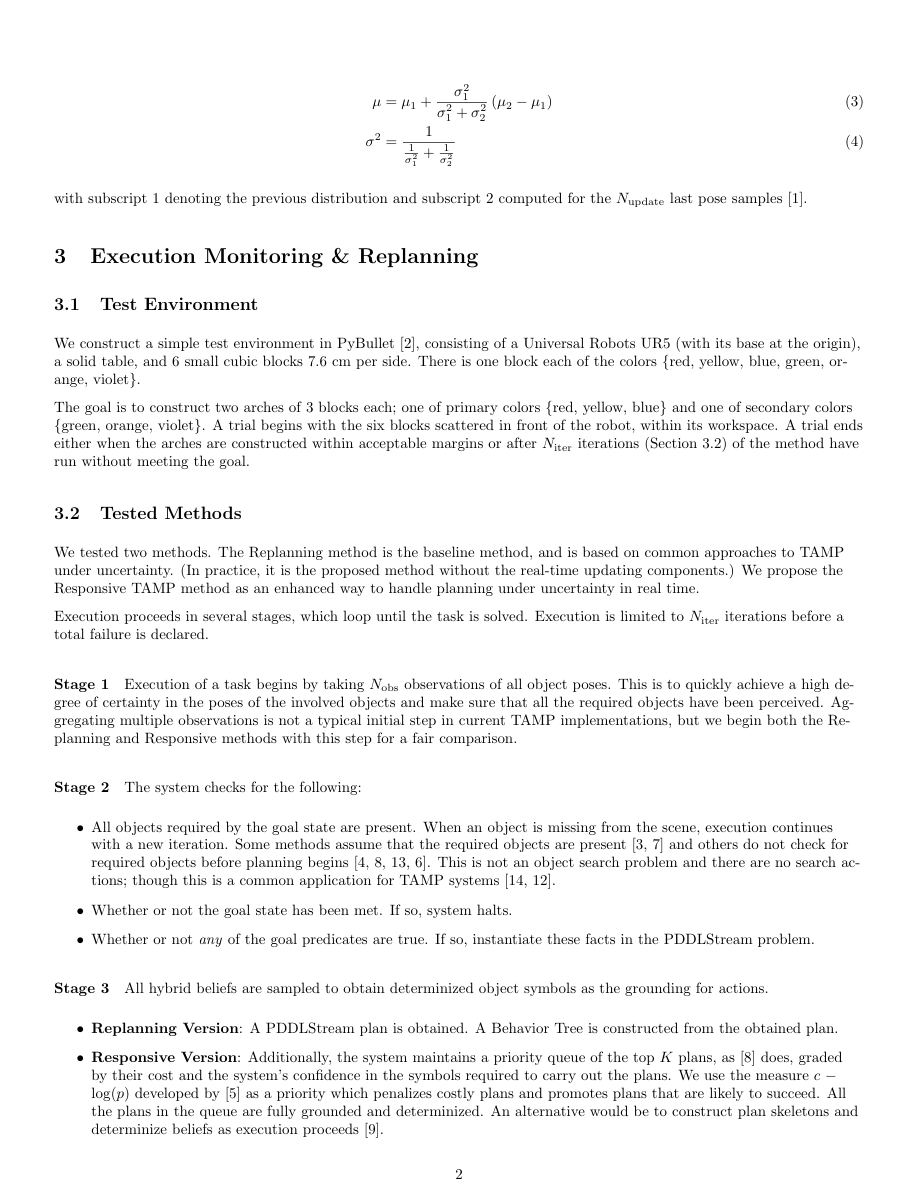

LLM query took 51.24 seconds to process!
(" The image you've provided appears to be a page from an academic paper or "
 'textbook discussing topics related to robotics and artificial intelligence. '
 'Specifically, it mentions "Estimation of Running Time of Robot Plan" in the '
 'context of monitoring performance. However, there is no direct answer on how '
 'to estimate the running time of a robot plan based on confidence in the '
 'current state estimate.\n'
 '\n'
 'Estimating the running time of a robot plan involves various factors such as '
 'the complexity of the task, the quality and robustness of the planning '
 'algorithm, the precision of the current state estimate, and the efficiency '
 "of the robot's hardware and software. Additionally, confidence in the "
 'current state estimate can be affected by factors like sensor accuracy, '
 'uncertainty in the environment, and the adaptability of the planning system '
 'to changes in its operation.\n'
 '\n'
 'To estimate the runnin

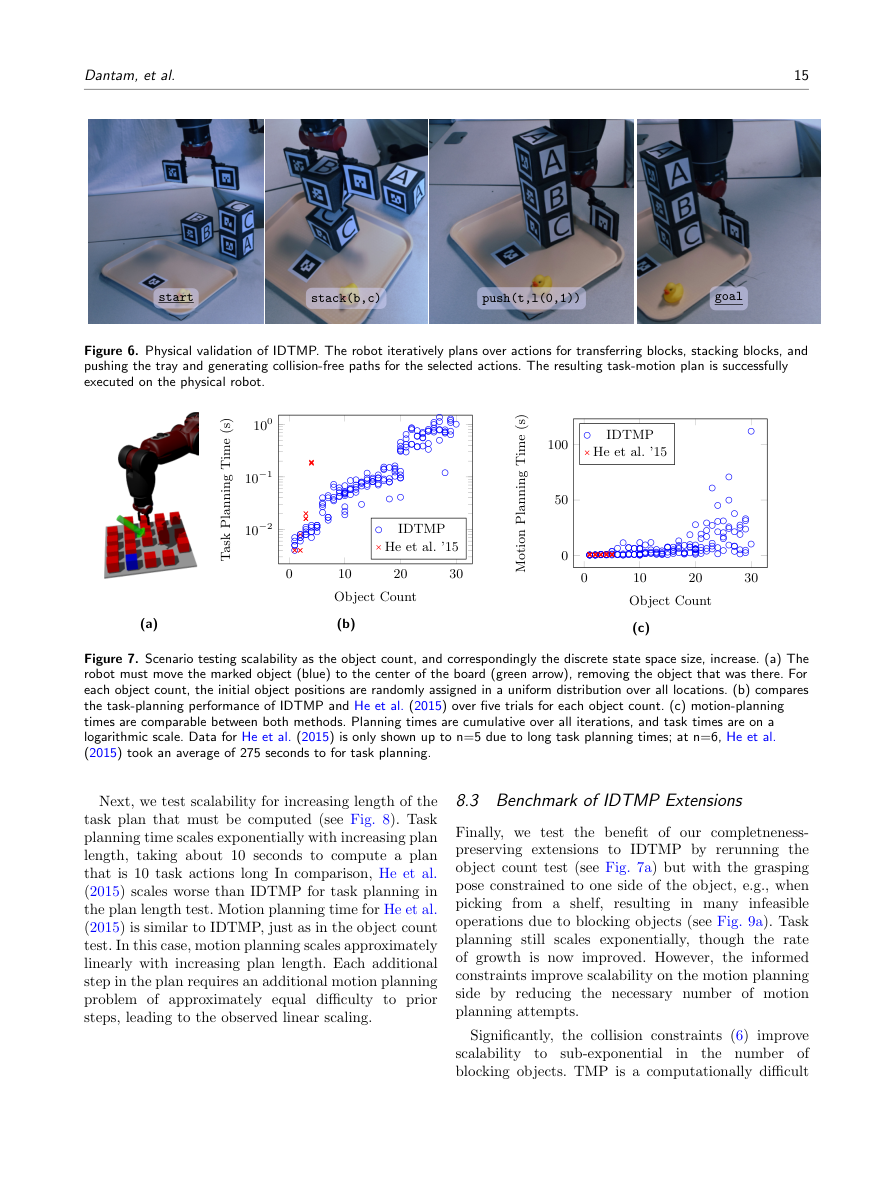

LLM query took 39.01 seconds to process!
(' The image you provided appears to be a page from an academic paper or '
 'article discussing the estimation of robot plan running time based on '
 'confidence in the current state estimate. While I cannot read the full text, '
 'I can provide you with some general guidance on how such an estimation might '
 'be approached:\n'
 '\n'
 '1. **Define Confidence Metric**: Develop a metric to quantify confidence in '
 'the current state estimate. This could be a measure of the distance between '
 'the actual and estimated position, a measure of variance in the state '
 'estimate, or some other suitable measure.\n'
 '\n'
 '2. **Predict Running Time**: Use machine learning or control theory '
 'algorithms to predict the running time of the robot plan based on the '
 'confidence metric. This prediction could be made by analyzing the historical '
 'performance of similar robots in similar situations and using this '
 'information to generate a model tha

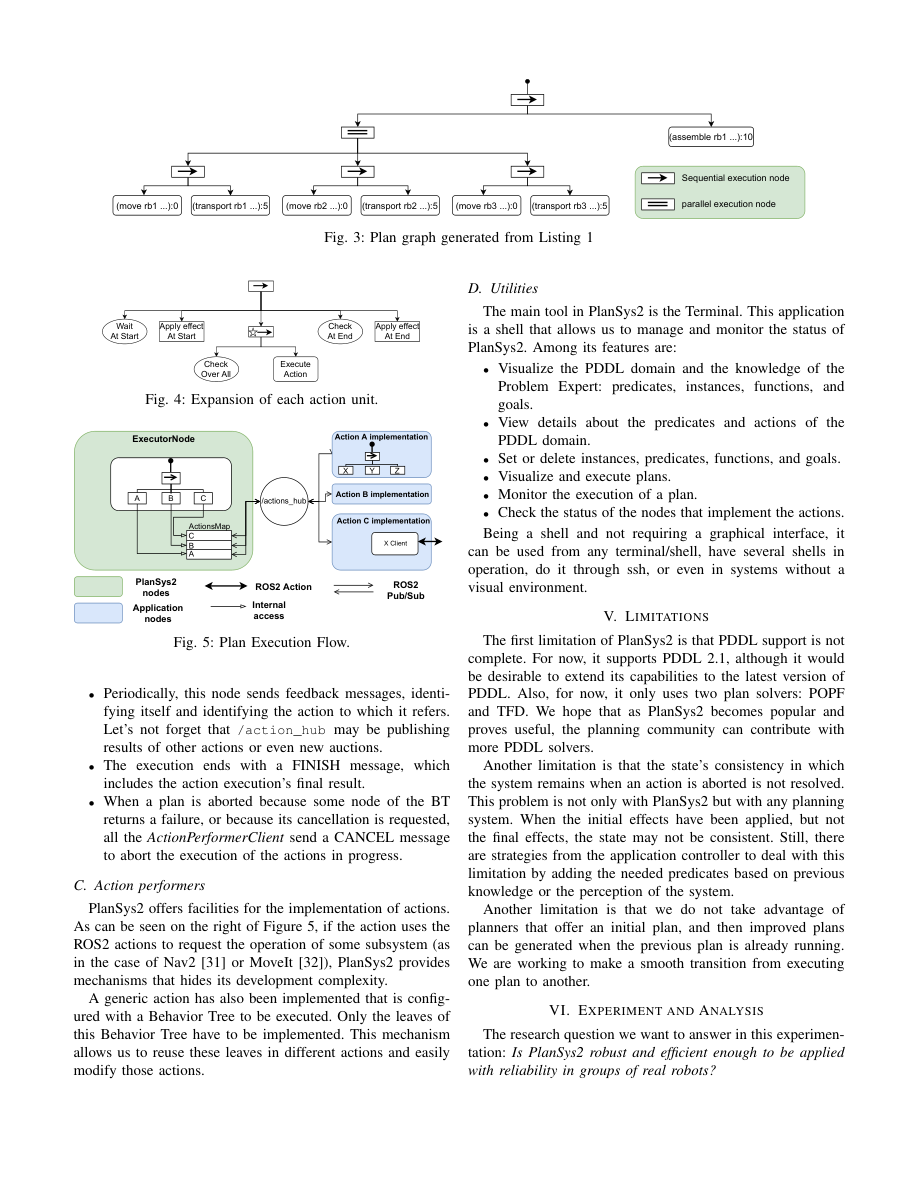

LLM query took 28.95 seconds to process!
(" The image you've provided is of a document that appears to be discussing "
 'the topic of estimating running time in robot planning. It seems to be '
 'related to machine learning or artificial intelligence (AI), specifically '
 'for autonomous systems, where the running time of a plan is an important '
 'aspect of performance evaluation and decision-making processes.\n'
 '\n'
 'In order to estimate the running time of a robot plan based on confidence in '
 'the current state estimate, you typically need to consider several factors:\n'
 '\n'
 '1. **Complexity of the Plan**: More complex plans often require more '
 'computation or execution steps, which can affect the running time.\n'
 '\n'
 '2. **Current State of the Environment**: If the environment has changed '
 "significantly from the initial plan's assumptions, the running time might be "
 'affected as the robot needs to adapt to new conditions.\n'
 '\n'
 '3. **Flexibility of the Plan**:

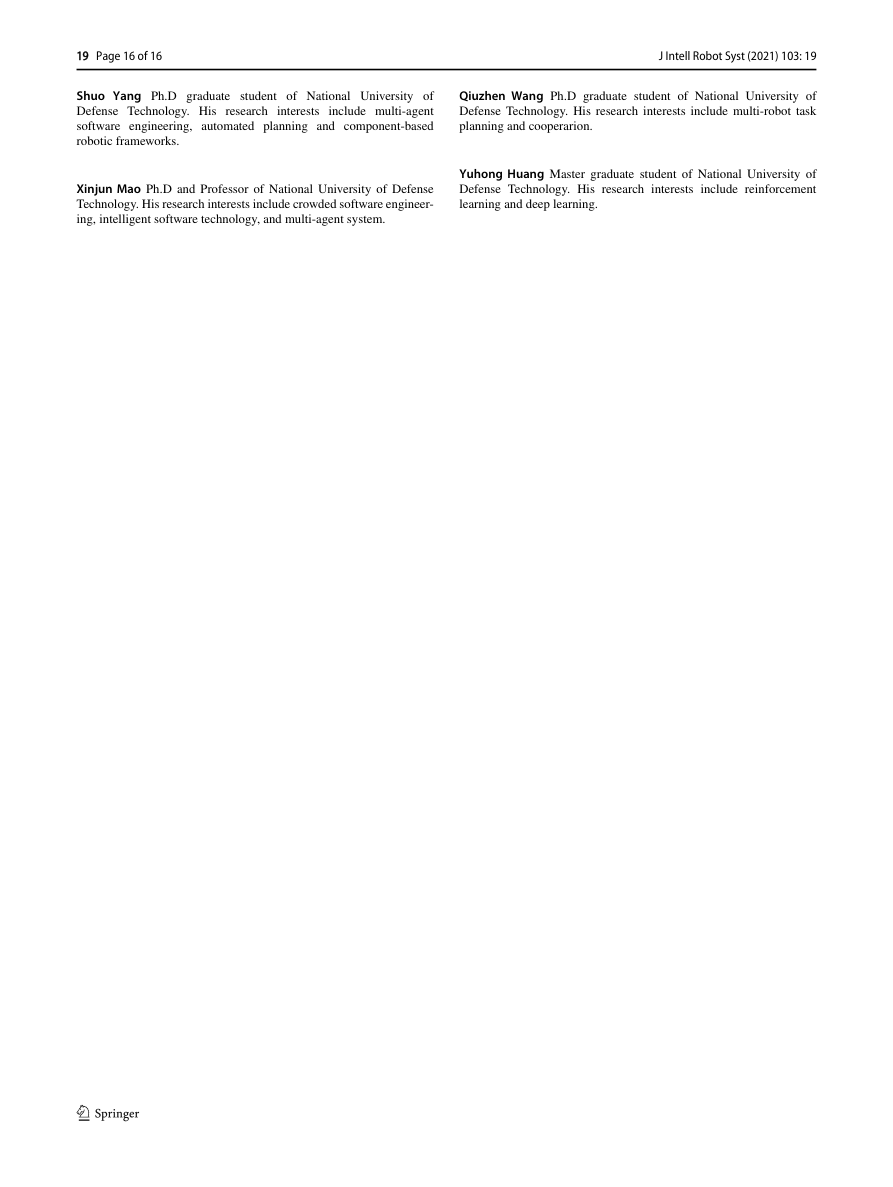

LLM query took 29.76 seconds to process!
(" The image you've provided appears to be a screenshot of a presentation "
 'slide or academic paper discussing the evaluation of a robot plan based on '
 'confidence in the current state estimate. To estimate the running time of a '
 'robot plan, one needs to consider various factors such as the complexity of '
 'the task, the speed of the robot, and the precision of the state '
 'estimation.\n'
 '\n'
 'When it comes to using confidence as an indicator for running time:\n'
 '\n'
 '1. **High Confidence**: When the robot has high confidence in its current '
 "state estimate, it's likely that the plan is well-executed and efficient. "
 "The robot may be able to complete tasks quickly because it's certain about "
 'its position and actions.\n'
 '\n'
 '2. **Low Confidence**: Conversely, if the robot has low confidence in its '
 'state estimate, it might take more time to execute the plan because it needs '
 'to explore different options before sett

In [17]:
if environ["_RAG_RUN_QUERY"]:
    deep_doc_ask( "How do I estimate the running time of a robot plan based on confidence in the current state estimate?" )

# arXiv Connectivity

* When using the legacy APIs (including OAI-PMH, RSS, and the arXiv API), make no more than one request every three seconds, and limit requests to a single connection at a time.
    - Suppose 1400 submissions a day, This will take at least 1.2h to download at 1 paper / 3s
* [Bulk Data Options](https://info.arxiv.org/help/bulk_data.html)
* Do they want donations for mass downloads?
* NOT allowed to serve files!
* NOT for profit!
* CANNOT redirect users to download
* [arXiv API Basics](https://info.arxiv.org/help/api/basics.html)
* [arXiv API Manual](https://info.arxiv.org/help/api/user-manual.html)